In [1]:
import nestpy
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import itertools

In [2]:
pip install xlrd

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install get-variable-name

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [4]:
#Detector identification
detector = nestpy.DetectorExample_XENON10()
# detector = nestpy.VDetector()
# Performing NEST calculations according to the given detector example       
nc = nestpy.NESTcalc(detector) #can also be left empty    

#GetInteractionObject grabs the number for the interaction you want so you don't have to always reference the dictionary. Just type e.g., 'ion'
#It just changes the name to a number for nestpy to do its work.

In [5]:
@np.vectorize
def GetYieldsVectorized(interaction, yield_type, **kwargs):
    yield_object = nc.GetYields(interaction = interaction, **kwargs)
    # returns the yields for the type of yield we are considering 
    return getattr(yield_object, yield_type)

# def PhotonYield(**kwargs):
#     return GetYieldsVectorized(yield_type = 'PhotonYield', **kwargs)
 
def ElectronYield(**kwargs):
    return GetYieldsVectorized(yield_type = 'ElectronYield', **kwargs)

# def Yield(**kwargs):
#     return {'photon' : PhotonYield(**kwargs),
#             'electron' : ElectronYield(**kwargs),
#            # What is missing?  Aren't there other parts of YieldObject?
#            }

In [6]:
fields=np.asarray([200.])
energies = np.logspace(-1, 2, 1000,)
energies = np.reshape(energies, (1000,1))
energies = np.broadcast_to(energies, (len(energies), len(fields)))

kwargs = {'energy': energies, 'drift_field': fields}
nr_electrons = ElectronYield(interaction=nestpy.INTERACTION_TYPE.NR, **kwargs)/energies #yields/keV

In [7]:
nr_electrons.shape

(1000, 1)

In [8]:
nestpy.INTERACTION_TYPE.NR

INTERACTION_TYPE.NR

In [9]:
@np.vectorize
def yields():
    nc.GetYields(interaction=0, energy=energies, drift_field=200)

In [10]:
interaction = nestpy.INTERACTION_TYPE(0)  # NR
interaction

INTERACTION_TYPE.NR

In [56]:
some_array = np.ones((5, 3))
some_df = pd.DataFrame(some_array, columns=['nr_energy', 'yield', 'sigmas'])

all_data = pd.read_csv('data csvs/qy.csv', usecols=[1, 3, 4, 16, 17])
all_data = all_data.set_index(['Field'])
all_fields = all_data.index.values.tolist()
all_fields = list(dict.fromkeys(all_fields))

everything = {}
#field, energy, qy
for field in all_fields:
    field_data = all_data.loc[field]
    var1 = field_data['EnergyCorr'].tolist()
    var2 = field_data['Q_y (e-/keVr)'].tolist()
    var3 = field_data['error'].tolist()
    variables = {var1[i]: [var2[i], var3[i]] for i in range(len(var1) - 4)} 
    everything[field]= variables  
everything[730][2] = [14.114, 2.8542]
#field, energy, qy, error
dahl = [60, everything[60], 'Dahl Xenon10']
dahl2 = [522, everything[522], 'Dahl Xenon10']
dahl3 = [876, everything[876], 'Dahl Xenon10']
dahl4 = [1951, everything[1951], 'Dahl Xenon10']
xe1t = [82, everything[82], 'Xenon1T 2019']
xe1t2 = [119.7, everything[116.7], 'Xenon1T 2018']
xe10 = [730, dict(itertools.islice(everything[730].items(), 16, 24)),'Xenon10']
case = [100, everything[100], 'Case']
pandax = [395.7, everything[395.7], 'PandaX']
lux_dd = [190, everything[190], 'Lux Run03 D-D']
columbia = [190, {4.95:[5.9, 0.3], 6.6:[5.8, 0.1], 10.62:[5.7, 0.1], 13.95:[6.2, 0.1]}, 'Columbia 2018']
livermore = [220, everything[220], 'Livermore 2019']
sorenson = [730, dict(itertools.islice(everything[730].items(), 0, 15)), 'Sorenson Xenon10']

all_experiments = [dahl, dahl2, dahl3, dahl4, xe1t, xe1t2, xe10, case, pandax, lux_dd, columbia, livermore, sorenson]
all_experiments.sort(key=lambda x: int(x[0]))

In [74]:
def chargeyields_nr(experiments, savefig=False):
    '''
    Goal: to make a scatter plot of all the different yields at various energies.
    '''
    plt.figure(1, figsize=(9,6))
    subplot1 = plt.subplot(1,1,1)
    for data in experiments:
        yields = []
        errors = []
        driftField = data[0]
        nr_energy = data[1].keys()
        all_vals = data[1].values()
        for lst in all_vals:
            yields.append(lst[0])
            errors.append(lst[1])
        name = [data[2], ":", driftField, "V/cm"]
        name = ' '.join(str(v) for v in name)
    #plotting the data
        subplot1.scatter(nr_energy, yields, label= name)
    #error bars
        plt.errorbar(nr_energy, yields, yerr=errors, fmt='o', barsabove=True)
    
    #plotting the nest curve
    subplot1.plot(energies, nr_electrons, '--', label='NEST: 200 V/cm')

    #Formatting to match NEST plots
    subplot1.set_xscale('log')
    subplot1.set_ylim(bottom=0)
    subplot1.legend(loc='upper right', fontsize= 9, ncol=1)    
    subplot1.set_xlabel('Recoil Energy [keV]')
    subplot1.set_title('Charge Yields for Nuclear Recoils')
    subplot1.set_ylabel('Charge Yield [n$_e$/keV]') 
    subplot1.margins(0)
    
    if savefig: 
        plt.savefig('qy.png')

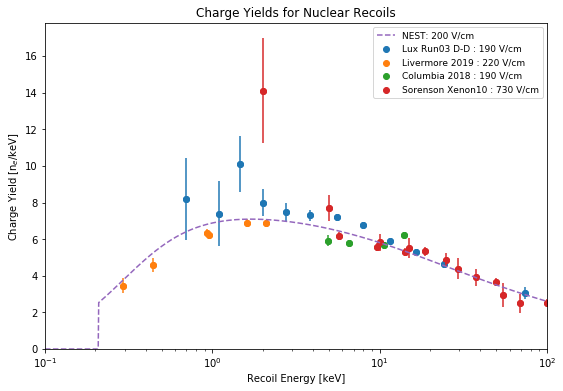

In [75]:
chargeyields_nr([lux_dd, livermore, columbia, sorenson])

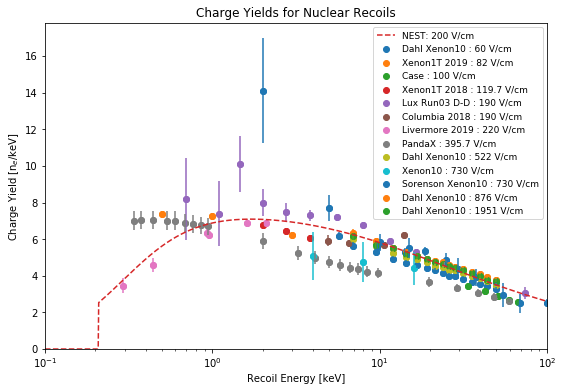

In [77]:
chargeyields_nr(all_experiments, True)